# Applying Super-Resolution on COCO Dataset
In this notebook, I apply the pretrained Super-Resolution CNN on 5000 images from COCO Detection 2017 dataset. Then, I finetune Faster R-CNN on the "enhanced" images.

# Prerequisities

In [1]:
%%shell
pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-8ycgyom_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-8ycgyom_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263919 sha256=b67d59d43949bb1715a2afa206f59798010030ec19561fbf4c947f3cb8cd31cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-exkfg_6w/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [9]:
import torch
import torch.nn as nn
from torchvision.datasets import VOCDetection, CocoDetection
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import os

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab_Notebooks/'
ASSIGNMENTNAME = 'instances_val2017.json'

%cd drive/My\ Drive
%cp -r $FOLDERNAME/$ASSIGNMENTNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


In [3]:
%%shell
git clone https://github.com/davidgu13/ML-for-Perception-Project.git

Cloning into 'ML-for-Perception-Project'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [75]:
dataDir='..'
dataType='val2017'
annFile=f'../instances_{dataType}.json'
coco=COCO(annFile) # 5000 COCO images (see their format in https://cocodataset.org/#format-data)

coco_images = coco.loadImgs(ids=coco.getImgIds())
git_folder_name = "ML-for-Perception-Project"
coco_folder_name = os.path.join("/content", git_folder_name, "coco_images")
if not os.path.isdir(coco_folder_name):
  os.mkdir(coco_folder_name)

dataset_size = 550 # Note: for 550 images, this loop takes ~10 minutes to run on GPU!
zero_objects_counter = 0
for j, img in enumerate(coco_images):
  if j==dataset_size: break
  if len(coco.loadAnns(coco.getAnnIds([img['id']])))==0:
    zero_objects_counter += 1
    # do not download images with no objects to detect !!!
  else:
    I = io.imread(img['coco_url'])
    io.imsave(os.path.join(coco_folder_name,f"img_{img['id']}.jpg"),I)
print(f"{zero_objects_counter} images were filtered because according to COCO they have no objects to detect!")

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: /content/ML-for-Perception-Project/coco_images/img_379453.jpg is a low contrast image


6 images were filtered because according to COCO they have no objects to detect!


In [83]:
# Print the datset size - should be equal to (dataset_size - #no_objects_images)
print(len([name for name in os.listdir(coco_folder_name) if os.path.isfile(os.path.join(coco_folder_name, name))]))

544


In [90]:
import re
c = 0 # count how many images have no objects to detect

for img_path in os.listdir(coco_folder_name):
  idx = int(re.findall(r'\d\d+',img_path)[0]) # get the "COCO index" of the image
  if len(coco.loadAnns(coco.getAnnIds([idx])))==0:
    c+=1
print(c) # the result should be 0!

0


In [91]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [92]:
# use url to load image
def show_img(imgId):
  img = coco.loadImgs([imgId])[0]
  I = io.imread(img['coco_url'])
  plt.axis('off')
  plt.imshow(I)
  plt.show()


# load and display instance annotations
def show_img_with_ann(imgId):
  img = coco.loadImgs([imgId])[0]
  I = io.imread(img['coco_url'])
  plt.axis('off')
  plt.imshow(I)
  annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
  anns = coco.loadAnns(annIds)
  coco.showAnns(anns, draw_bbox=True)

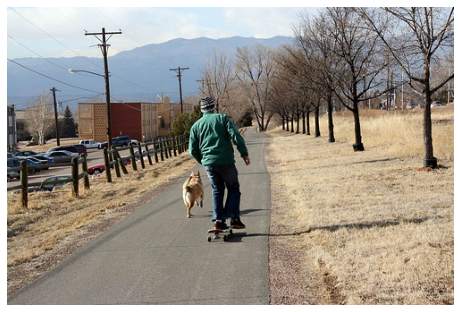

num_objs = 15
Object 0: category=dog, bbox=[196.51, 183.36, 23.95, 53.02], area=759.3375500000002, is_crowd=0
Object 1: category=car, bbox=[44.2, 161.19, 36.78, 13.78], area=331.9790999999998, is_crowd=0
Object 2: category=car, bbox=[22.89, 167.01, 29.48, 8.68], area=99.29444999999996, is_crowd=0
Object 3: category=car, bbox=[40.97, 154.53, 49.56, 13.77], area=284.7819500000001, is_crowd=0
Object 4: category=car, bbox=[80.38, 149.06, 28.02, 11.39], area=200.5696500000001, is_crowd=0
Object 5: category=car, bbox=[117.82, 144.6, 21.22, 11.43], area=180.31030000000015, is_crowd=0
Object 6: category=skateboard, bbox=[223.48, 243.72, 28.67, 19.61], area=409.74355, is_crowd=0
Object 7: category=car, bbox=[8.15, 167.26, 39.82, 20.85], area=405.7335000000002, is_crowd=0
Object 8: category=car, bbox=[90.26, 171.66, 49.58, 17.36], area=215.15389999999994, is_crowd=0
Object 9: category=car, bbox=[135.36, 148.4, 11.35, 7.23], area=55.564449999999944, is_crowd=0
Object 10: category=car, bbox=[9.04,

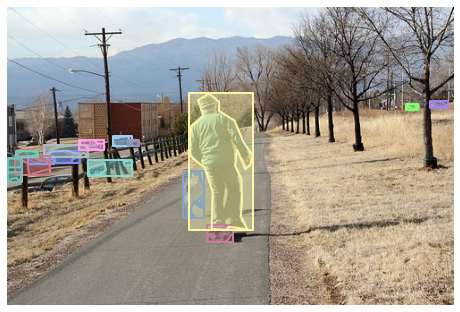

In [93]:
# Example:
img_id = 324158
img = coco.loadImgs([img_id])[0]
show_img(img_id)
show_img_with_ann(img_id)

coco_annotations = coco.loadAnns(coco.getAnnIds(imgIds=img['id']))

num_objs = len(coco_annotations)
objects_cat_ids = coco.loadCats([e['category_id'] for e in coco_annotations])

categories = [e['name'] for e in objects_cat_ids]
print(f"num_objs = {num_objs}")
boxes, areas, is_crowds = [], [], []
for i in range(num_objs):
  curr_object = coco_annotations[i]
  category = categories[i] # curr_object['name']
  bbox = curr_object['bbox']
  area = curr_object['area']
  iscrowd = curr_object['iscrowd']
  print(f"Object {i}: category={category}, bbox={bbox}, area={area}, is_crowd={iscrowd}")

  areas.append(area)
  boxes.append(bbox) 
  is_crowds.append(iscrowd)

boxes = torch.as_tensor(boxes, dtype=torch.float32)
areas = torch.as_tensor(areas, dtype=torch.float32)
is_crowd = torch.as_tensor(is_crowds, dtype=torch.int64)
img_id = torch.tensor([img_id])
# labels = torch.ones((num_objs,), dtype=torch.int64)

In [94]:
# print(os.getcwd())
# os.chdir(git_folder_name) # uncomment if needed
print(os.getcwd())
git_folder_name = "ML-for-Perception-Project"
assert os.getcwd()== os.path.join("/content", git_folder_name)
if not os.path.isdir("coco_images_enhanced"):
  os.mkdir("coco_images_enhanced")

import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image

from models import SRCNN
from utils import convert_rgb_to_ycbcr, convert_ycbcr_to_rgb, calc_psnr
import os
import time

cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SRCNN().to(device)

weights_file = "srcnn_x2.pth"

state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)
# model.eval()


def test(model, image_file: str, scale: int, src_folder: str, dest_folder: str):
  model.eval()
  image = pil_image.open(os.path.join(src_folder,image_file)).convert('RGB')

  image_width = (image.width // scale) * scale
  image_height = (image.height // scale) * scale
  image = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
  image = image.resize((image.width // scale, image.height // scale), resample=pil_image.BICUBIC)
  image = image.resize((image.width * scale, image.height * scale), resample=pil_image.BICUBIC)
  # image.save(image_file.replace('.', '_bicubic_x{}.'.format(scale))) # commented as it's not better than SRCNN

  image = np.array(image).astype(np.float32)
  ycbcr = convert_rgb_to_ycbcr(image)

  y = ycbcr[..., 0]
  y /= 255.
  y = torch.from_numpy(y).to(device)
  y = y.unsqueeze(0).unsqueeze(0)

  with torch.no_grad():
      preds = model(y).clamp(0.0, 1.0)
  psnr = calc_psnr(y, preds)
  print('PSNR: {:.2f}'.format(psnr))
  preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

  output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
  output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
  output = pil_image.fromarray(output)
  output.save(os.path.join(dest_folder,image_file.replace('.', '_srcnn_x2.')))

/content/ML-for-Perception-Project


In [95]:
for i,f in enumerate(os.listdir("coco_images")):
    print(f"Image {i}:", end=' ')
    test(model, f, 2, "coco_images", "coco_images_enhanced")
# Creating the upgraded dataset is completed.

Image 0: PSNR: 31.43
Image 1: PSNR: 37.10
Image 2: PSNR: 37.19
Image 3: PSNR: 38.56
Image 4: PSNR: 29.19
Image 5: PSNR: 36.75
Image 6: PSNR: 34.82
Image 7: PSNR: 39.77
Image 8: PSNR: 32.93
Image 9: PSNR: 35.34
Image 10: PSNR: 33.13
Image 11: PSNR: 35.91
Image 12: PSNR: 33.04
Image 13: PSNR: 34.32
Image 14: PSNR: 36.35
Image 15: PSNR: 34.19
Image 16: PSNR: 43.35
Image 17: PSNR: 30.26
Image 18: PSNR: 35.16
Image 19: PSNR: 32.02
Image 20: PSNR: 39.14
Image 21: PSNR: 36.77
Image 22: PSNR: 39.28
Image 23: PSNR: 35.52
Image 24: PSNR: 37.69
Image 25: PSNR: 34.64
Image 26: PSNR: 41.56
Image 27: PSNR: 30.73
Image 28: PSNR: 36.44
Image 29: PSNR: 33.52
Image 30: PSNR: 32.97
Image 31: PSNR: 33.54
Image 32: PSNR: 43.09
Image 33: PSNR: 32.83
Image 34: PSNR: 40.82
Image 35: PSNR: 36.28
Image 36: PSNR: 34.59
Image 37: PSNR: 43.97
Image 38: PSNR: 35.06
Image 39: PSNR: 37.06
Image 40: PSNR: 36.08
Image 41: PSNR: 35.44
Image 42: PSNR: 35.61
Image 43: PSNR: 32.31
Image 44: PSNR: 37.17
Image 45: PSNR: 36.8

In [34]:
%%shell
# Download helper functions for the training
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

# cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 1990, done.
remote: Counting objects: 100% (1990/1990), done.
remote: Compressing objects: 100% (441/441), done.
remote: Total 21208 (delta 1546), reused 1899 (delta 1498), pack-reused 19218
Receiving objects: 100% (21208/21208), 21.52 MiB | 15.95 MiB/s, done.
Resolving deltas: 100% (15604/15604), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [96]:
# Now that we're done with generating the super-reolution images, let's move to using the pretraind Faster R-CNN (using the 3rd assignment code).
# Make sure to upload the files used in the assignment: 
import torchvision 
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

# load a Faster RCNN model pre-trained on COCO 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

def load_image(img_path):
  """
  The function uses PIL.Image to load image from image_path.
  It transforms the image into a tensor and returns it.
  """
  # PIL.Image loads a image from a given path.
  # The result value is a numpy array
  img = Image.open(img_path)
  # Using pytorch 'transforms' we convert it to a tensor
  transform = transforms.Compose([transforms.ToTensor()])
  img = transform(img) # Apply the transform to the image
  return img

def make_prediction(model, img_path, device="cuda"):
  """
  The function load the image from image_path,
  move image and model to the device (gpu or cpu) 
  and do a forward pass (inference) using the given model
  """
  # model to device
  model = model.to(device)
  # load image
  img = load_image(img_path)
  # image to device
  img = img.to(device)
  # make a prediciton
  pred = model([img])
  return pred

def plot_predictions(image_path, boxes, pred_cls=None, box_thickness=8, txt_size=3, txt_thickness=3):
    """
    The function load image from image_path using cv2 and draw bounding boxes (```boxes```)
    and classes (```pred_cls```) [if given] near each bounding box.
    """
    # re-load image with cv2 
    img = cv2.imread(image_path)
    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plot boxes
    for i in range(len(boxes)):
      cv2.rectangle(img, (boxes[i][0],boxes[i][1]), (boxes[i][2],boxes[i][3]),color=(0, 255, 0), thickness=box_thickness) # Draw Rectangle with the coordinates
      if pred_cls is not None:
        # plot labels if given
        print(pred_cls[i])
        cv2.putText(img,pred_cls[i], (boxes[i][0],boxes[i][1]),  cv2.FONT_HERSHEY_SIMPLEX, txt_size, (0,255,0),thickness=txt_thickness) # Write the prediction class
    # show image
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.show()

def filter_predictions(raw_preds, threshold):
    """
    The function gets ```raw_preds``` - a dictionary with all model predictions
    (boxes, labels and confidence scores) and filter those with score < threshold.
    It returns pred_boxes (the remaining bounding boxes) and pred_class
    (the corresponding remaining labels).
    """
    # get all bounding boxes
    raw_bounding_boxes = raw_preds['boxes'].detach().cpu().numpy()
    # get all labels
    raw_labels = raw_preds['labels'].detach().cpu().numpy()
    # get confidence scores for each box.
    pred_score = raw_preds['scores'].detach().cpu().numpy()

    raw_labels = list(raw_labels)
    pred_score = list(pred_score)
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in raw_labels] 
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] 
    pred_boxes = raw_bounding_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    ######################
    return pred_boxes, pred_class


def detection_inference(model, image_path, threshold, box_thickness=8, txt_size=3, txt_thickness=3):
    """
    A template function for detection inference:
    1. Load image from ```image_path```
    2. Forward pass to get raw predictions
    3. Filter predictions with confidence scores lower than ```threshold```
    4. Plot image with bounding boxes and labels.
    """
    # first set model to eval mode (always before inference)
    model.eval()
    # make a prediction
    raw_preds = make_prediction(model,image_path, device="cuda")[0]
    # filter predictions by confidence scores
    pred_boxes, pred_class = filter_predictions(raw_preds, threshold=threshold)
    # plot bounding boxes with labels
    plot_predictions(image_path, pred_boxes, pred_class, box_thickness, txt_size, txt_thickness)
    return pred_boxes, pred_class

/content
giraffe
giraffe
giraffe


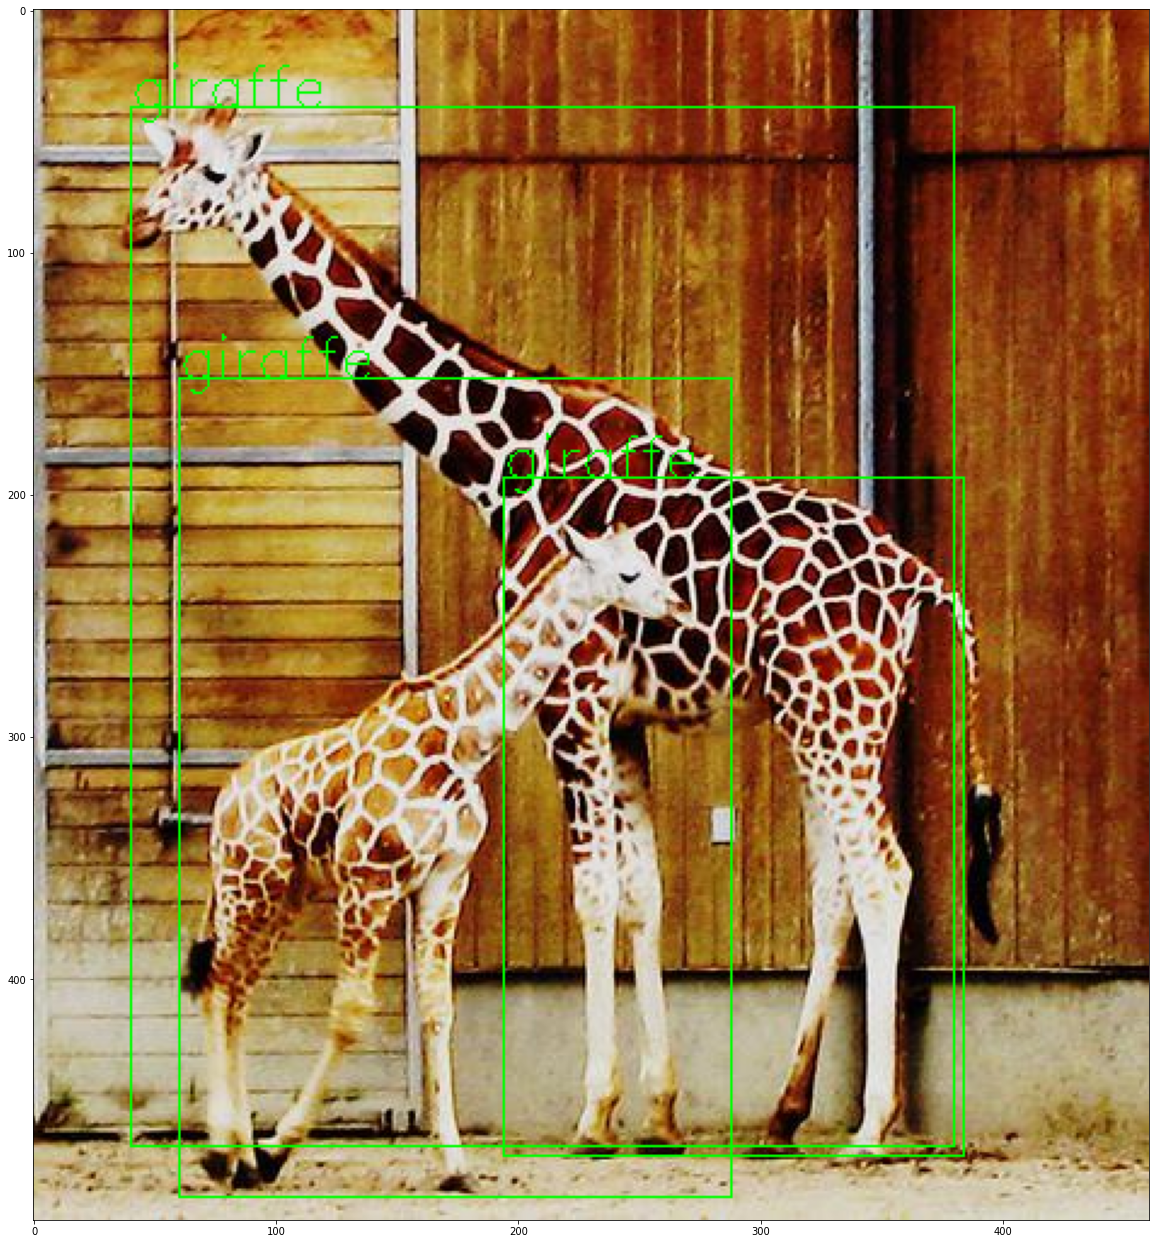

{'boxes': array([[ 40.696407,  40.160942, 380.37552 , 469.05823 ],
       [ 60.355164, 152.81195 , 288.17987 , 490.63156 ],
       [194.91832 , 193.62598 , 384.2278  , 473.10568 ]], dtype=float32), 'classes': ['giraffe', 'giraffe', 'giraffe']}


In [97]:
%cd "/content/ML-for-Perception-Project/"
assert os.getcwd()=='/content/ML-for-Perception-Project'
image_path = os.path.join("coco_images","img_153299.jpg")
model.eval() # first set model to eval mode (always before inference)
# preds = make_prediction(model,img_path=image_path, device=device)[0] # call ```make_prediction```
# print(preds) # print preds

# call detection inference above with threshold=50%
boxes, classes = detection_inference(model, image_path, threshold=0.5, box_thickness=1, txt_size=0.8, txt_thickness=1)
print({'boxes':boxes, 'classes':classes})

In [100]:
# The improved dataset
import pdb
import re
import utils
class COCOEnhancedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        super(COCOEnhancedDataset, self).__init__()
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root)))
        # self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        # mask = Image.open(mask_path)
        # Adjusted to COCO:
        coco_idx = int(re.findall(r'\d\d+',img_path)[0])
        ann_id = coco.getAnnIds([coco_idx])
        anns = coco.loadAnns(ann_id)
        # print(len(anns))
        mask = coco.annToMask(anns[0])
        for i in range(len(anns)):
            mask += coco.annToMask(anns[i])

        mask = pil_image.fromarray(mask)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            # handle degenerate boxes!
            if xmin>=xmax:
              xmax = xmin + 0.2 
            if ymin>= ymax:
              ymax = ymin + 0.2
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)


import transforms as T
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [101]:
# use our dataset and defined transformations
print(os.getcwd())
if not os.getcwd()=='/content/ML-for-Perception-Project':
  os.chdir('content/ML-for-Perception-Project')
dataset_path = os.path.join(os.getcwd(),'coco_images_enhanced')
dataset = COCOEnhancedDataset(dataset_path, get_transform(train=True))
dataset_test = COCOEnhancedDataset(dataset_path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
print(f"train set length is {len(dataset)}")
print(f"test set length is {len(dataset_test)}")

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

print(f"No. of train batches is {len(data_loader)}")
print(f"No. of test batches is {len(data_loader_test)}")

from torchvision.models.detection import faster_rcnn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
      
def get_object_detection_model(num_classes):
    # load a Faster-RCNN object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# next(iter(data_loader))

/content/ML-for-Perception-Project
train set length is 494
test set length is 50
No. of train batches is 247
No. of test batches is 50


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [103]:
from engine import train_one_epoch, evaluate

num_epochs = 5
# %cd /content/SRCNN-pytorch/
print(os.getcwd())
# took ~50 minutes to run:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/content/ML-for-Perception-Project


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/247]  eta: 0:07:13  lr: 0.000025  loss: 0.3158 (0.3158)  loss_classifier: 0.0770 (0.0770)  loss_box_reg: 0.1679 (0.1679)  loss_objectness: 0.0494 (0.0494)  loss_rpn_box_reg: 0.0215 (0.0215)  time: 1.7531  data: 0.3042  max mem: 8227
Epoch: [0]  [ 10/247]  eta: 0:09:45  lr: 0.000228  loss: 0.3314 (0.5931)  loss_classifier: 0.0794 (0.0839)  loss_box_reg: 0.1335 (0.1408)  loss_objectness: 0.0565 (0.0712)  loss_rpn_box_reg: 0.0602 (0.2972)  time: 2.4689  data: 0.0360  max mem: 8227
Epoch: [0]  [ 20/247]  eta: 0:09:41  lr: 0.000431  loss: 0.3322 (0.5238)  loss_classifier: 0.0944 (0.0951)  loss_box_reg: 0.1365 (0.1496)  loss_objectness: 0.0565 (0.0627)  loss_rpn_box_reg: 0.0462 (0.2164)  time: 2.6043  data: 0.0093  max mem: 8227
Epoch: [0]  [ 30/247]  eta: 0:09:00  lr: 0.000634  loss: 0.3855 (0.4923)  loss_classifier: 0.0946 (0.0958)  loss_box_reg: 0.1423 (0.1514)  loss_objectness: 0.0511 (0.0676)  loss_rpn_box_reg: 0.0462 (0.1774)  time: 2.5022  data: 0.0094  max mem: 8227


person
person


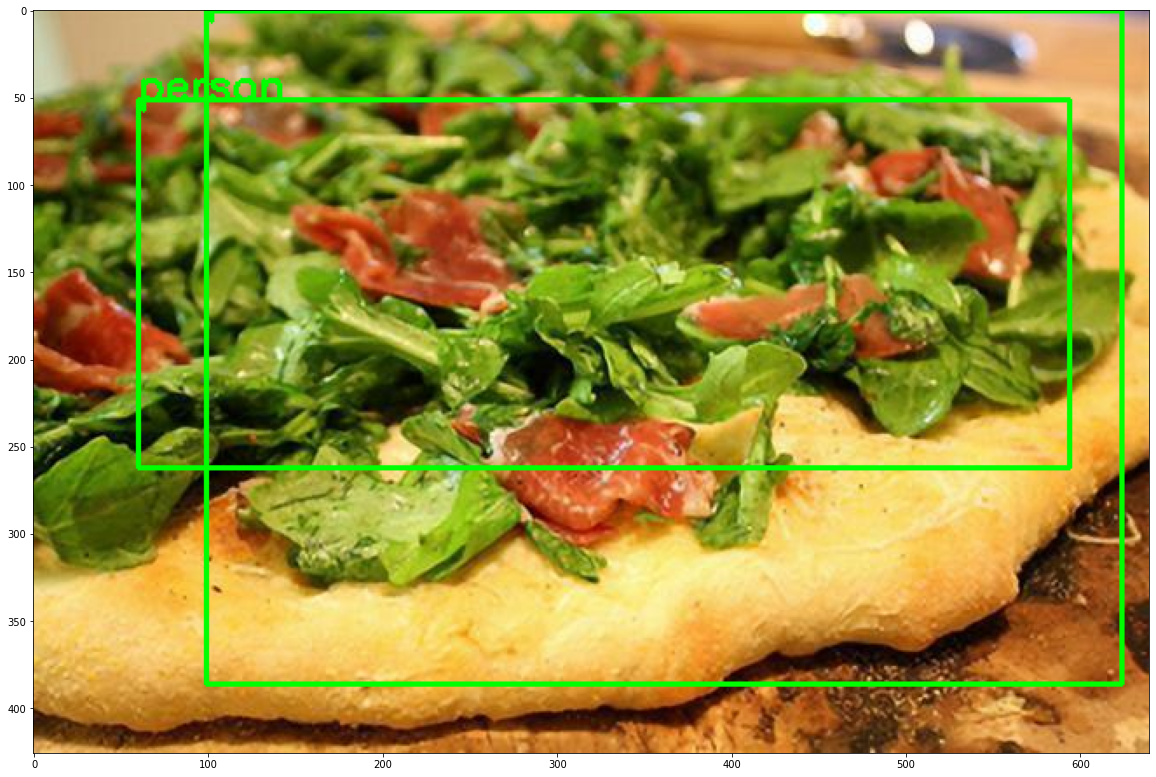

(array([[ 99.29002,   0.     , 624.51025, 386.2765 ],
        [ 60.66925,  51.53744, 594.9436 , 262.5516 ]], dtype=float32),
 ['person', 'person'])

In [106]:
detection_inference(model, '/content/ML-for-Perception-Project/coco_images_enhanced/img_100582_srcnn_x2.jpg', threshold=0.5, box_thickness=2, txt_size=0.8, txt_thickness=2)

person
person
person
person


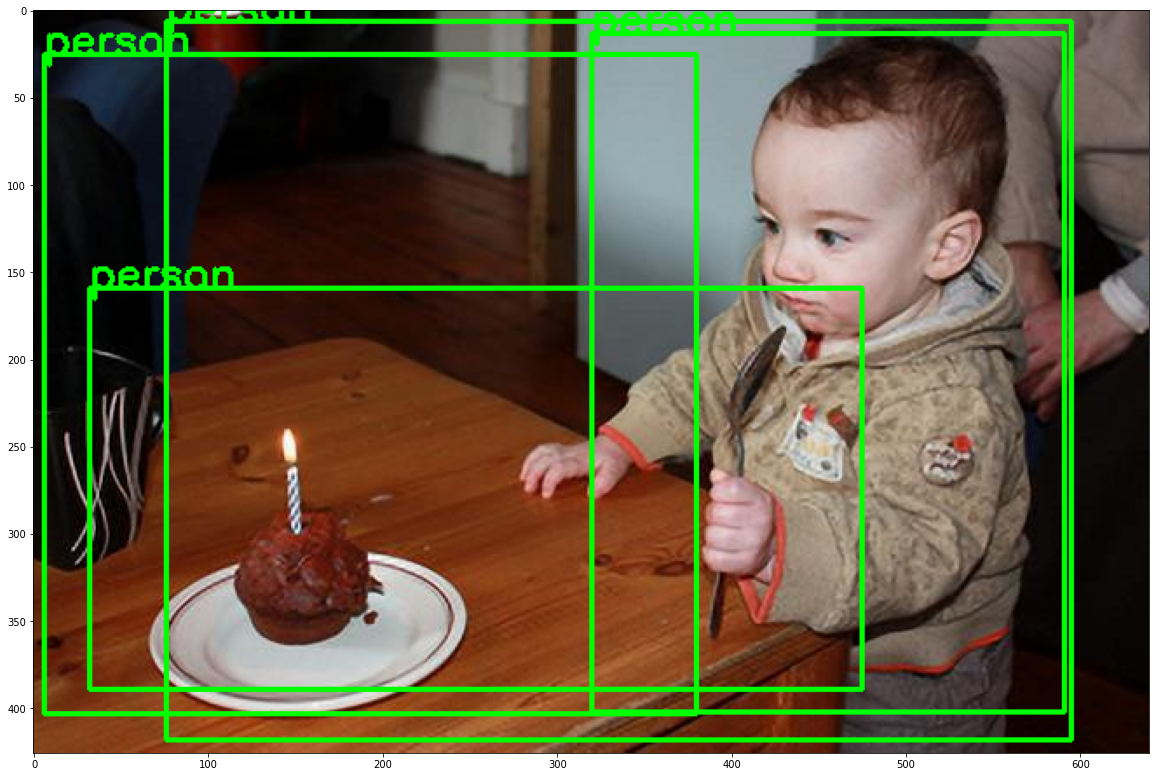

(array([[ 76.386246,   6.168586, 595.95416 , 418.694   ],
        [320.68604 ,  13.038141, 591.70886 , 402.00613 ],
        [ 32.175285, 159.18808 , 475.83997 , 389.30893 ],
        [  6.471755,  25.762972, 380.99725 , 403.34674 ]], dtype=float32),
 ['person', 'person', 'person', 'person'])

In [107]:
detection_inference(model, '/content/ML-for-Perception-Project/coco_images_enhanced/img_117425_srcnn_x2.jpg', threshold=0.5, box_thickness=2, txt_size=0.8, txt_thickness=2)

person
person
person
person


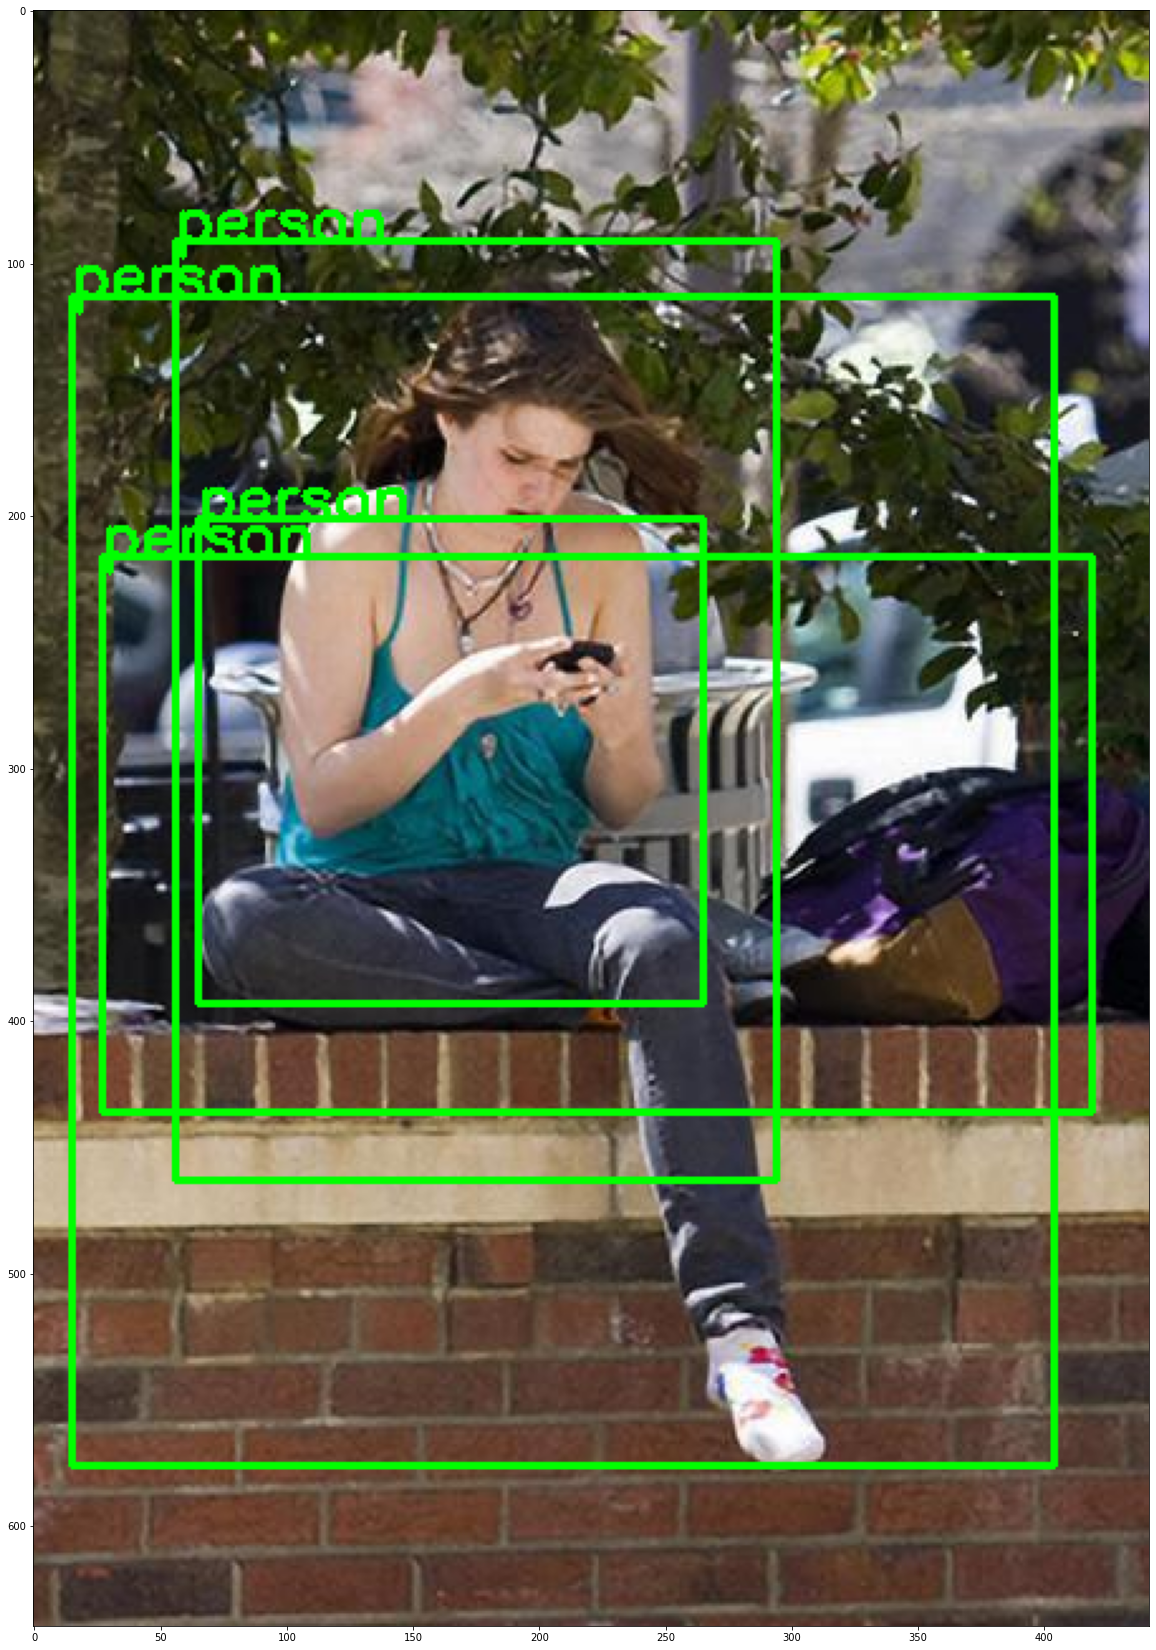

(array([[ 15.507314, 113.433945, 404.94574 , 576.13727 ],
        [ 27.068302, 216.6469  , 419.77255 , 436.54172 ],
        [ 56.86572 ,  91.46768 , 294.59576 , 463.1323  ],
        [ 65.31998 , 201.84286 , 265.4068  , 393.02914 ]], dtype=float32),
 ['person', 'person', 'person', 'person'])

In [109]:
detection_inference(model, '/content/ML-for-Perception-Project/coco_images_enhanced/img_281414_srcnn_x2.jpg', threshold=0.5, box_thickness=2, txt_size=0.8, txt_thickness=2)